# Context and Objectives

The advancement of industrial Internet of Things (IoT) and industrial Big Data Analytics has spurred huge promise of economic values through data-driven predictive modeling in a variety of industries. Fault detection and prognostics are common problems in industrial plant monitoring and are at the core of systems health management.  
One of the most important tasks in prognostics is Remaining Useful Life (RUL) prediction, in units of time (e.g., hours or cycles). The objective of RUL prediction is to estimate the remaining working time of a system before its health condition deteriorates below a threshold indicating a faulty condition. 

In the age of Internet of Things and Industrial 4.0, the prognostic and health management (PHM) systems are used to collect massive real-time data from the mechanical equipment, through the use of sensors that capture the asset behaviour over time. This technological advent creates a paradigm shift that opens up significant business opportunities. The direct costs and reputation loss caused by poor asset reliability can significantly impact organizational performance. The ability to predict an asset's reliability is therefore a core capability. 

Reliably estimating the RUL of an asset is an opportunity that decision makers need to seize in order to save costs. RUL predictions help *avoid unscheduled maintenance*, *increase equipment usage* as well as *improve operational safety*. The US Department of Energy found that predictive maintenance can **cut on-going maintenance costs by up to 30%, eliminate 75% of breakdowns, and reduce energy consumption by up to 20%**. In addition, a report by Deloitte University Press, <a href=" https://www2.deloitte.com/insights/us/en/focus/industry-4-0/manufacturing-ecosystems-exploring-world-connected-enterprises.html">Industry 4.0 and manufacturing ecosystems</a>, provides examples in which, for companies like Schneider Electric and Caterpillar, predictive maintenance and understanding root cause of failures **can offer millions of dollars in potential savings along with far fewer days of equipment downtime**.
RUL estimates provide decision makers with information that allows them to change operational characteristics (such as load) which in turn may prolong the life of the component. It also allows planners to account for upcoming maintenance and set in motion a logistics process that supports a smooth transition from faulty equipment to fully functional. Aircraft engines, medical equipment, power plants, etc. are some of the common examples of these types of equipment. 

In this challenge, we will be using aircraft engines Run-to-Failure simulated data, from the <a href="https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/">Prognostics Data Repository</a>.
The Dataset consists of a multivariate sensory data collected from the engines operating from normal to failure. The engine starts with different degrees of initial wear and manufacturing variation.  This wear and variation is considered normal, i.e., it is not considered a fault condition. 
There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. In additon, the data is contaminated with sensor noise.
The engine is operating normally at the start of the time serie, and develops a fault at some point during the serie. In the training set, the fault grows in magnitude until system failure. In the test set, the time series end some time prior to system failure. The RUL estimates are in units of time (cycles for engines)


# Presenting the data

The dataset is constructed of 26 dimensions/columns, wherein the first column is the unit number for different engines, the second column is the time index (cycle), the third through fifth columns are the settings of operational conditions, and the other 21 columns are simulated sensory data. 
The train data covers the Run-to-Failure process of 100 testing engines and consists of 20,631 data points. The test data contains the data collected in the running process with no failures, which is used to predict when the failure will occur—in other words, to estimate the RUL. The operational conditions of train and test are the same but have different initial states, which are caused by the variant initial wear and manufacture bias.





# Evaluation metric
The objective of the challenge is to predict the number of remaining operational cycles before failure in the test set, i.e., 
the number of operational cycles after the last cycle that the engine will continue to operate.

For results evaluation, estimated RULs are compared with actual RULs provided in the RUL column of the test data. In PHM context, it is generally desirable to have early RUL estimates rather than late RULs. Another criterion is the accuracy of prognostics model evaluated by **the Root Mean Squared Error** or **RMSE**, since it penalizes large errors severely, which will force the algorithm to forecast RUL as accurately as possible.

$$ RMSE = \sqrt{\frac{1}{n}\sum_{i=0}^n (y_i - \hat{y_i})^2} $$

# Loading the data

Data source <a href="https://c3.nasa.gov/dashlink/resources/139/">here.</a> 

In [39]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.ensemble import RandomForestRegressor , AdaBoostRegressor, GradientBoostingRegressor
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
import os
import IPython.display as dis

%matplotlib inline

np.random.seed(8)
path = os.getcwd()

pd.options.display.max_columns = 100

In [40]:
data = pd.read_csv(os.path.join(path, "data", "train.txt"), sep=' ')

In [41]:
data.unit=data.unit.astype(int)

In [42]:
data.describe()

,unit,os1,os2,os3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
count,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000,20631.000000
mean,51.506568,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,21.609803,553.367711,2388.096652,9065.242941,1.3,47.541168,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705,107.807862
std,29.227633,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,0.001389,0.885092,0.070985,22.082880,0.0,0.267087,0.737553,0.071919,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251,68.880990
min,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,21.600000,549.850000,2387.900000,9021.730000,1.3,46.850000,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200,0.000000
25%,26.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,21.610000,552.810000,2388.050000,9053.100000,1.3,47.350000,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800,51.000000
50%,52.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,21.610000,553.440000,2388.090000,9060.660000,1.3,47.510000,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900,103.000000
75%,77.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,21.610000,554.010000,2388.140000,9069.420000,1.3,47.700000,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800,155.000000
max,100.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,21.610000,556.060000,2388.560000,9244.590000,1.3,48.530000,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400,361.000000


In [43]:
data.dtypes

unit      int64
os1     float64
os2     float64
os3     float64
s1      float64
s2      float64
s3      float64
s4      float64
s5      float64
s6      float64
s7      float64
s8      float64
s9      float64
s10     float64
s11     float64
s12     float64
s13     float64
s14     float64
s15     float64
s16     float64
s17     float64
s18     float64
s19     float64
s20     float64
s21     float64
RUL     float64
dtype: object

As indicated below, there are 100 differents units in the data

In [44]:
len(np.unique(data['unit']))

100

For some sensors, the distributions of the thresholds for several units are almost the same 

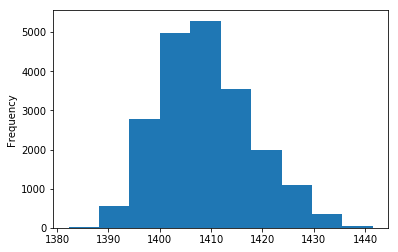

In [45]:
data['s4'].plot.hist()

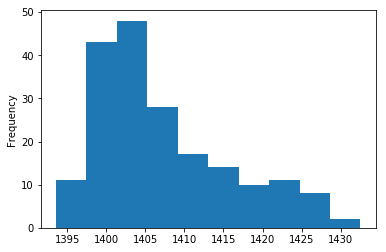

In [46]:
data[data['unit']==1]['s4'].plot.hist()

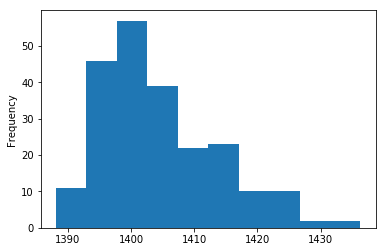

In [47]:
data[data['unit']==10]['s4'].plot.hist()

On the other hand, some sensors seem to have constant values:

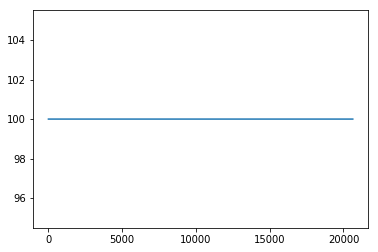

In [48]:
data['s19'].plot()

For each unit, we have records of sensors only before reaching a failure once.

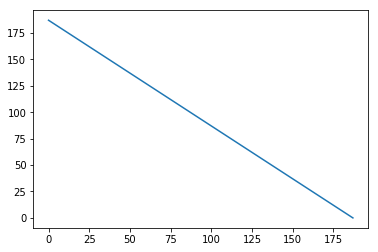

In [49]:
data[data['unit']==6].reset_index()['RUL'].plot()

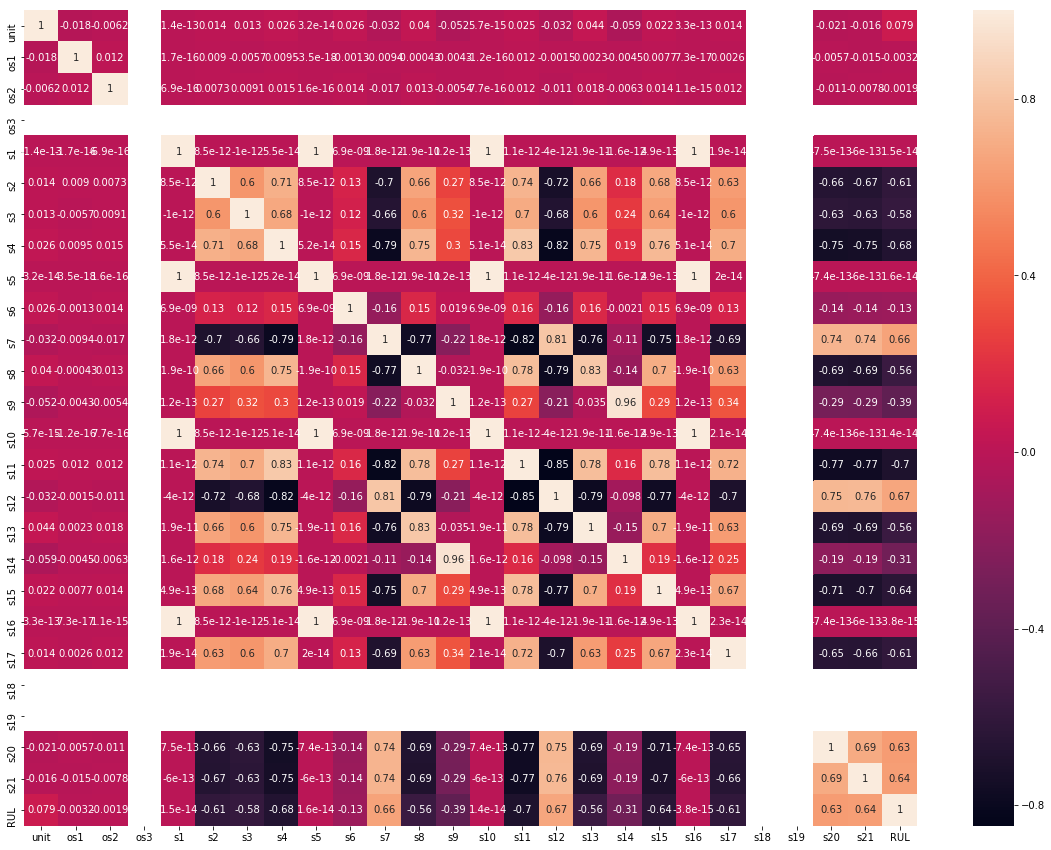

In [50]:
import seaborn as sns
corr = data.corr()
plt.subplots(figsize=(20,15))
sns.heatmap(corr, 
            xticklabels=data.columns.values,
            yticklabels=data.columns.values,annot=True)

# Exploratory Data Analysis

### Feature extraction


In [62]:
%%file submissions/starting_kit/feature_extractor.py

class FeatureExtractor(object):
    def __init__(self):
        pass

    def fit(self, X_df, y_array):
        pass

    def transform(self, X_df):
        return X_df.drop("unit",axis=1)

Overwriting submissions/starting_kit/feature_extractor.py


### The regressor

In [63]:
%%file submissions/starting_kit/regressor.py
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestRegressor


class Regressor(BaseEstimator):
    
    def __init__(self):
        self.reg = RandomForestRegressor()

    def fit(self, X, y):
        return self.reg.fit(X, y)

    def predict(self, X):
        return self.reg.predict(X)

Overwriting submissions/starting_kit/regressor.py


## Local testing (before submission)

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. For this we provide a unit test. Note that the test runs on your files in [`submissions/starting_kit`](/tree/submissions/starting_kit), not on the classes defined in the cells of this notebook.

First `pip install ramp-workflow` or install it from the [github repo](https://github.com/paris-saclay-cds/ramp-workflow). Make sure that the python files `feature_extractor.py` and `regressor.py` are in the  [`submissions/starting_kit`](/tree/submissions/starting_kit) folder, and the data `train.csv` and `test.csv` are in [`data`](/tree/data). Then run

```ramp_test_submission```

If it runs and print training and test errors on each fold, then you can submit the code.

In [70]:
!ramp_test_submission 

Testing Predictive maintenance
Reading train and test files from ./data ...
Reading cv ...
Training ./submissions/starting_kit ...
CV fold 0
./submissions/starting_kit/regressor.py:1: RuntimeWarning: Parent module '.submissions.starting_kit' not found while handling absolute import
  from sklearn.base import BaseEstimator
./submissions/starting_kit/regressor.py:2: RuntimeWarning: Parent module '.submissions.starting_kit' not found while handling absolute import
  from sklearn.ensemble import RandomForestRegressor
	score  mean error
	train       0.270
	valid       0.591
	test        0.452
CV fold 1
	score  mean error
	train       0.254
	valid       0.619
	test        0.457
CV fold 2
	score  mean error
	train       0.257
	valid       0.595
	test        0.448
----------------------------
Mean CV scores
----------------------------
	score      mean error
	train   0.26 ± 0.0071
	valid  0.602 ± 0.0125
	test   0.452 ± 0.0036
----------------------------
Bagged scores
-------------------------